# Aim of this talktorial

In this talktorial, we will get familiar with the natural of the neural network , types of its layers and different types of activation function .Furthermore, I will build neural network model composed from two hidden layer to take the MACC fingerprints of drugs and their PIC50 as Epidermal growth factor receptor (EGFR) inhibitor and training the model to predict the PIC50. Finally, I will use the model on unknown smiles for predict their PIC50 values and determine which compounds will be good as (EGFR) inhibitor drugs.  

# Learning goals


## Theory

* Molecular fingerprints
* Compound activity measures (IC50)
* EGFR Kinase 

## Practical

* load molecules from CHEMBL25_activities_EGFR.csv
* Smiles
* MACC keys of compounds 
* Neural network model
* choose the most appropriate batch sizes
* 5-fold cross-validation
* loading and Testing the model on EGFR_test_set.csv
* prediction  of pic50 of smiles in New file
* comparison between prediction with neural network and convolutional neural network


# References

* [Talktorial 4 (Ligand-based screening: compound similarity](https://github.com/volkamerlab/TeachOpenCADD/blob/master/talktorials/4_mol_similarity/T4_mol_similarity.ipynb)
* https://link.springer.com/article/10.1186/s13321-018-0311-x
* https://towardsdatascience.com/understanding-neural-networks-19020b758230
* https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html
* http://rdkit.org/docs/source/rdkit.Chem.MACCSkeys.html
* https://blog.quantinsti.com/backpropagation/
* https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6


# Theory

## ChEMBL database
The ChEMBL is a dataset developed by the European Bioinformatics Institute providing information regarding the SMILES (Simplified Molecular Input Line Entry System), chemical properties activity and genomics of over 1.9 billion compounds.Amoge these compoudes , I used some drugs with their smiles and PIC50.

## Molecular fingerprints

Molecular fingerprints represent the chemical structures in bit strings form as each position mean the presence (1) or absence (0) of chemical features as defined in the design of the fingerprint.one of common fingerprint is molecular ACCess System (MACCS) fingerprints (MACCS Keys) which are 166 bits structural key descriptors in which each bit is associated with a SMARTS pattern  which is the same as smiles with some extensions and flexibility [SMARTS :A Language for Describing Molecular Patterns](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html)
[RDKit documentation: MACCS keys](http://rdkit.org/docs/source/rdkit.Chem.MACCSkeys.html)

## Compound activity measures (IC50)

IC50 is half maximal concentration of inhibitory drug to inhibit the activity of specific enzyme and in our case the Epidermal growth factor receptor as its Inhibition helps in slow down or stop cancer cell growth. Using **pIC50** (the negative log of the IC50 value) because it is easy for interpretation than IC50 and common for potency of compounds 

## EGFR

Epidermal growth factor receptor (EGFR) is a transmembrane protein activated by binding of its specific ligands and it included in the cell growth process. It is also be found at high levels on some types of cancer cells, which causes these cells to grow and divide quickly so one of the approaches in treatment the cancer is inhibiting EGFR receptor. To determine the efficacy of drugs that can inhibit EGFR we measure IC50 (PIC50) to the drug and in this project, we will build model to predict the PIC50 of drugs from its smiles and fingerprint.

# Practical

## required Libraries

Nmpy, pandas, Rdkit, matplotlib.pyplot, seaborn, sklearn, tensorflow , Keras

In [1]:
# import Libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
# libraries neural network
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

##  load molecules from CHEMBL25_activities_EGFR.csv

In [3]:
path = (r'https://raw.githubusercontent.com/Ahmed-fub/'
        'Neural-Network-to-predict-EGFR-of-drugs/master/data/CHEMBL25_activities_EGFR.csv')

In [4]:
smil_pic50_df = pd.read_csv(path)

In [5]:
smil_pic50_df.head()

,Unnamed: 0,chembl_id,IC50,units,canonical_smiles,pIC50
0,1777,CHEMBL207869,77.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
1,5785,CHEMBL3940060,330.0,nM,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
2,6373,CHEMBL3678951,1.0,nM,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000
3,2442,CHEMBL504034,40.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,7.397940
4,1084,CHEMBL158797,43000.0,nM,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,4.366531


## smiles

In [6]:
smiles = smil_pic50_df['canonical_smiles']
smiles.head(3)

0    Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1
1    ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...
2    FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...
Name: canonical_smiles, dtype: object

# MACC keys of compounds 

In [7]:
def smil_to_maccfp(smile):

    """
    convert smiles to Molecular ACCess System (MACCS) fingerprints

    parameters:
    --------------
    smile: str
           smile of the molecule
    Returns:
    -----------
    nparray
          macc fingerprint of the molecule in form of list

    """
    # construct the molecule from smile
    mole = Chem.MolFromSmiles(smile)
    # forming MACC fingerprint from the molecue
    macc = MACCSkeys.GenMACCSKeys(mole)
    # convert MACC fp to array
    bitlist = np.asarray(macc)
    return(bitlist)

In [8]:
# convert all smiles in the file to MACC keys
macc_fp_df = pd.DataFrame([smil_to_maccfp(smile) for smile in smiles])
macc_fp_df.shape

(3906, 167)

In [9]:
macc_fp_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0


## Data frame of  MACCS fingerprint of molecules and their PIC50

In [10]:
# adding pic50 column
maccs__fp_df_pic50 = macc_fp_df.join(smil_pic50_df['pIC50'])
maccs__fp_df_pic50.head()

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,pIC50
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,1,1,0,7.113509
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,6.481486
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,0,1,0,9.000000
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,7.397940
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,4.366531


In [11]:
# separate the inputs keys fp and the output pic50
keys = maccs__fp_df_pic50.iloc[:, maccs__fp_df_pic50.columns != 'pIC50']
pic50 = maccs__fp_df_pic50.iloc[:, -1]

In [12]:
# separate the macc_keys, pic50 to training set and testing set
keys_train, keys_test, pic50_train, pic50_test = train_test_split(
    keys, pic50, test_size=0.3, random_state=42)

In [13]:
keys_train.shape

(2734, 167)

In [14]:
keys_test.shape

(1172, 167)

## Neural network model

This overview figure for the model
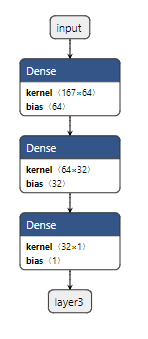
image by Netron application

In [15]:
def NN_model(hidden1, hidden2):
    """
    creating neural network from two hidden layer
    using relu as activation function in two hidden layer
    and linear in the output layer

    parameters
    ----------
    hidden1 : Int
              number of neuons in first hidden layer

    hidden2: Int
             number of neuons in second hidden layer
    Returns
    --------
    model fully connected neural network model with two hidden layer
    """

    model = Sequential()
    # first hidden layer
    model.add(Dense(hidden1, activation='relu', name="layer1"))
    # dropout prevent overfitting
    Dropout(.5)
    # second headden layer
    model.add(Dense(hidden2, activation='relu', name="layer2"))
    Dropout(.5)
    # output layer
    model.add(Dense(1, activation='linear', name="layer3"))

    # compile model

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
    return model

### choose the most appropriate batch sizes 

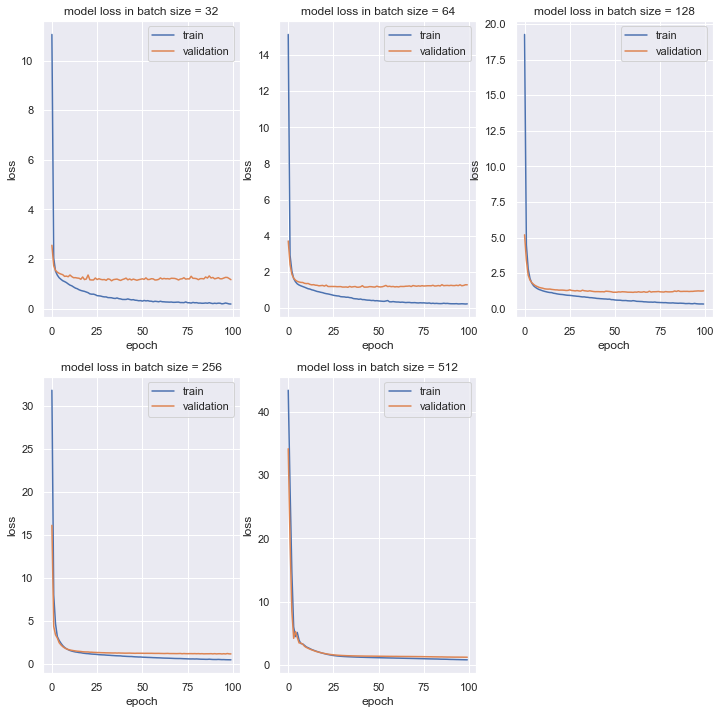

In [16]:
# trying different batch sizes

batch_sizes = [32, 64, 128, 256, 512]
# size of figure
fig = plt.figure(figsize=(12, 12))
sns.set(color_codes=True)
for i in range(1, 6):

    fig.add_subplot(2, 3, i)
    # creat new model
    model = NN_model(64, 32)
    history = model.fit(keys_train, pic50_train, batch_size=batch_sizes[i-1],
                        validation_data=(keys_test, pic50_test),
                        verbose=0, epochs=100)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss in batch size = '+str(batch_sizes[i-1]))
plt.show()

## 5-fold cross-validation

In [17]:
# cross validation

# take the values of both keys and pic50 to can be divided
x = keys.values
y = pic50.values

kf = KFold(5, shuffle=True, random_state=42)  # split the data to 5 fold

MSE = []  # empty list to add mean square error to all 5 folds

for j, (train, test) in enumerate(kf.split(keys)):

    print(f"Fold #{j+1}")

    x_train = x[train]  # macc_keys for training
    y_train = y[train]  # pic50 for training
    x_test = x[test]    # macc_keys for testing
    y_test = y[test]    # pic50 for tsting

    model = NN_model(64, 32)

    model.fit(x_train, y_train, batch_size=512, verbose=0, epochs=100)

    pred = model.predict(x_test)

    score = metrics.mean_squared_error(pred, y_test)

    print(f"MSE score for fold{j+1}: {score}")

    MSE.append(score)

# MSE for all 5 fold
print('=================================================')
print(f'all MSE for 5 CV:{MSE}')

std_all_MSE = np.std(MSE)
mean_all_MSE = np.mean(MSE)

print("================================================")

print(f"mean:{mean_all_MSE}")
print(f"standard deviation:{std_all_MSE}")

Fold #1
MSE score for fold1: 1.3104662657759025
Fold #2
MSE score for fold2: 1.0700082423076323
Fold #3
MSE score for fold3: 0.9696342586157445
Fold #4
MSE score for fold4: 1.1189436434937516
Fold #5
MSE score for fold5: 1.269323591538728
all MSE for 5 CV:[1.3104662657759025, 1.0700082423076323, 0.9696342586157445, 1.1189436434937516, 1.269323591538728]
mean:1.147675200346352
standard deviation:0.126376815694862


## Training new model on all data set 


Epoch 00001: loss improved from inf to 27.35666, saving model to weights_CV.best.hdf5

Epoch 00002: loss improved from 27.35666 to 9.16460, saving model to weights_CV.best.hdf5

Epoch 00003: loss improved from 9.16460 to 4.67331, saving model to weights_CV.best.hdf5

Epoch 00004: loss improved from 4.67331 to 4.03647, saving model to weights_CV.best.hdf5

Epoch 00005: loss improved from 4.03647 to 3.18069, saving model to weights_CV.best.hdf5

Epoch 00006: loss improved from 3.18069 to 2.93525, saving model to weights_CV.best.hdf5

Epoch 00007: loss improved from 2.93525 to 2.51911, saving model to weights_CV.best.hdf5

Epoch 00008: loss improved from 2.51911 to 2.33034, saving model to weights_CV.best.hdf5

Epoch 00009: loss improved from 2.33034 to 2.11717, saving model to weights_CV.best.hdf5

Epoch 00010: loss improved from 2.11717 to 1.97804, saving model to weights_CV.best.hdf5

Epoch 00011: loss improved from 1.97804 to 1.86948, saving model to weights_CV.best.hdf5

Epoch 00012


Epoch 00094: loss improved from 0.68731 to 0.67835, saving model to weights_CV.best.hdf5

Epoch 00095: loss improved from 0.67835 to 0.67277, saving model to weights_CV.best.hdf5

Epoch 00096: loss did not improve from 0.67277

Epoch 00097: loss improved from 0.67277 to 0.66340, saving model to weights_CV.best.hdf5

Epoch 00098: loss improved from 0.66340 to 0.65606, saving model to weights_CV.best.hdf5

Epoch 00099: loss improved from 0.65606 to 0.64798, saving model to weights_CV.best.hdf5

Epoch 00100: loss improved from 0.64798 to 0.64723, saving model to weights_CV.best.hdf5
123/123 [==============================] - 0s 2ms/step - loss: 0.6357 - mse: 0.6357 - mae: 0.6102
score:[0.6356931924819946, 0.6356931924819946, 0.6102411150932312]


Text(0.5, 1.0, 'Regression of prdicted keys with the model and original pic50 ')

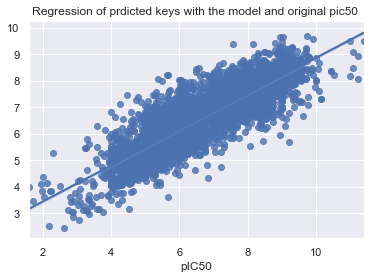

In [18]:
# creat new model

model = NN_model(64, 32)

# save the model
filepath = "weights_CV.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
                             save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit(keys, pic50, epochs=100, batch_size=512,
          callbacks=callbacks_list, verbose=0)

score = model.evaluate(keys, pic50)
print(f'score:{score}')

# predict all data
pred = model.predict(keys)

# ploting to distribution of training data around the model
sns.set(color_codes=True)
ax = sns.regplot(x=pic50, y=pred)
ax.set_title('Regression of prdicted keys with the model and original pic50 ')

#  loading and Testing the model on EGFR_test_set.csv

In [19]:
path_test_file = (r'https://raw.githubusercontent.com/Ahmed-fub/'
                  'Neural-Network-to-predict-EGFR-of-drugs/master/data/EGFR_test_set.csv')

In [20]:
test_df = pd.read_csv(path_test_file)

In [21]:
test_df.head()

,id,canonical_smiles
0,1,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1
1,2,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1
2,3,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1
3,4,O=C(/C=C/CN1CC[NH+](C)CC1)N1Cc2sc3ncnc(N[C@H](...
4,5,S(=O)(=O)(NC(=O)Cn1c(C)ncc1[N+](=O)[O-])c1ccc(...


In [22]:
smil_test = test_df['canonical_smiles']

In [23]:
# convert all smiles in test file to maacc keys
maccs_test_df = pd.DataFrame([smil_to_maccfp(smile) for smile in smil_test])
maccs_test_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,0


# prediction  of pic50 of smiles in New file

In [25]:
# load the model and predict the new smiles in test file
model = load_model("production_model.hdf5")
predicted_pic50 = model.predict(maccs_test_df)

In [26]:
# adding the predicted pic50 to their smiles in df
predicted_pic50 = pd.DataFrame(predicted_pic50, columns=['T04_predictions'])
predicted_pic50_df = test_df.join(predicted_pic50)

predicted_pic50_df.head(3)

,id,canonical_smiles,T04_predictions
0,1,S(Cc1c([O-])c(OC)cc(/C=C(\C#N)/C(=O)N)c1)c1ccccc1,5.779419
1,2,S=C(N)N1C(c2ccc(OC)cc2)CC(c2cc(C)c(C)cc2)=N1,5.483405
2,3,Clc1c(O)cc(-c2nn(C(C)C)c3ncnc(N)c23)cc1,5.343009


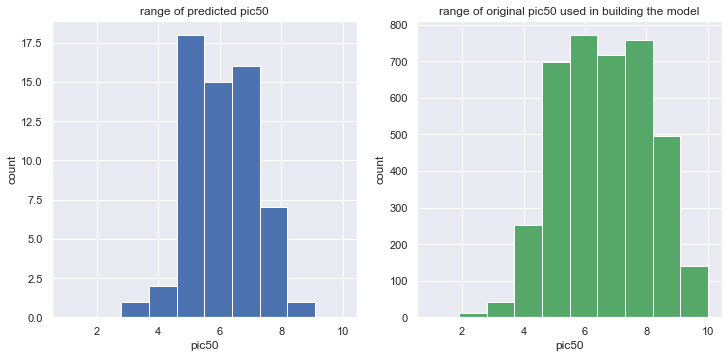

In [27]:
# Histogram to the distribution of the predected pic50 in test file
plt.figure(figsize=(12, 12))
sns.set(color_codes=True)

plt.subplot(221)
plt.hist(predicted_pic50_df["T04_predictions"],
         facecolor='b', histtype='barstacked', range=(1, 10))
plt.xlabel('pic50')
plt.ylabel('count')
plt.title('range of predicted pic50')

plt.subplot(222)
plt.hist(maccs__fp_df_pic50["pIC50"], facecolor='g', range=(1, 10), bins=10)
plt.xlabel('pic50')
plt.ylabel('count')
plt.title('range of original pic50 used in building the model')
plt.show()
sns.set()

**The drugs that can be used as Epidermal growth factor receptor inhibitor with higher value of PIC50** 

In [28]:
predicted_pic50_df_top3 = predicted_pic50_df.nlargest(3, 'T04_predictions')
predicted_pic50_df_top3

,id,canonical_smiles,T04_predictions
9,10,Brc1cc(Nc2ncnc3nc(NC)ccc23)ccc1,8.481803
53,54,c1cc(ccc1Nc2c(c(nc[nH+]2)NCCCn3cc[nH+]c3)N)I,8.144417
18,19,Clc1c(F)ccc(NC=2N=CNC=3C=2C=C(OCCCCC=C=C)C(=O)...,8.120270


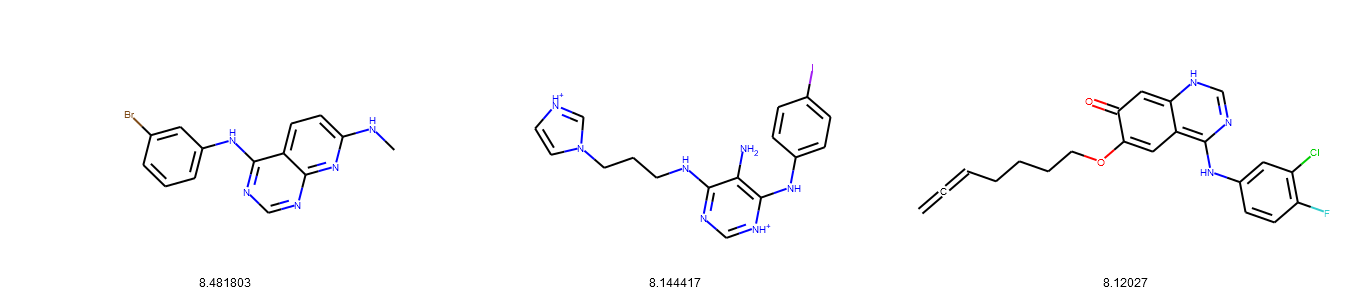

In [29]:
# draw prdicted molecules to be good EGFR inhibitors drugs
highest_pic50 = predicted_pic50_df['canonical_smiles'][[9, 53, 18]]

mols_EGFR = [Chem.MolFromSmiles(smile) for smile in highest_pic50]
pic50_EGFR = predicted_pic50_df_top3['T04_predictions'].astype(str).tolist()

Draw.MolsToGridImage(mols_EGFR, molsPerRow=3, subImgSize=(450, 300), legends=pic50_EGFR)

It is shown from the figures of molecules that there are similarities between them such as :

* aniline group 
* pyrimidine group (2 nitrogen instead of two carbon ) 
* 3 aromatic groups 
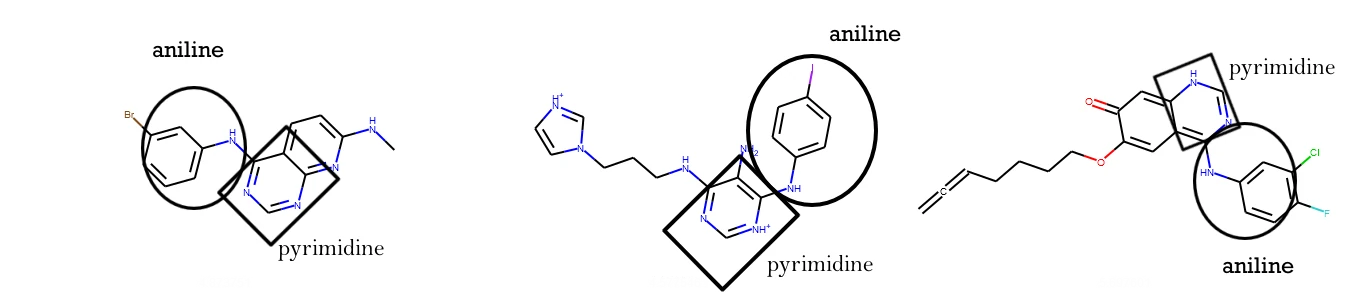


## Advantage of  this model for prediction pic50 from their fingerprint keys.

1. There is no time consuming as laboratory experiments and cheap.
2. It gives general overview about the possible drugs can be used as EGFR inhibitor drugs.

## Disadvantage: 
It does not have enough information about:
1. The model is changed with more variables and there is no fixed procedure to follow in building model. 
2. side effect of the compounds and their toxicity on normal cells.
3. The stereochemistry , stability and also their metabolite that can be produce by liver enzymes and other chemical properties of compounds as it can be used or no.

In general , this Neural network model for prediction of pic50 of molecules form their keys is good as overview to the possible drugs  that can be used in experiments. Therefore , we can reduce the number of experiments on a lot of compounds but I think we cannot take direct molecules from ML models and be 100% assure that these best compounds as EGFR inhibitors drugs. 